# Gyümi klasszifikáció Transfer Learning-el

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers, datasets, preprocessing
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import sys, os

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [2]:
# dataset = foz.load_zoo_dataset("open-images-v6", )
# Setting up Kaggle API
!pip install kaggle
!mkdir ~/.kaggle
!cp 'drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/toth-peter/.kaggle’: File exists
cp: cannot stat 'drive/MyDrive/Colab Notebooks/kaggle.json': No such file or directory


In [3]:
# Download Fruits dataset (kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition)
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

401 - Unauthorized


In [4]:
# Unzip it
!mkdir data
!unzip fruit-and-vegetable-image-recognition -d data/

mkdir: cannot create directory ‘data’: File exists
unzip:  cannot find or open fruit-and-vegetable-image-recognition, fruit-and-vegetable-image-recognition.zip or fruit-and-vegetable-image-recognition.ZIP.


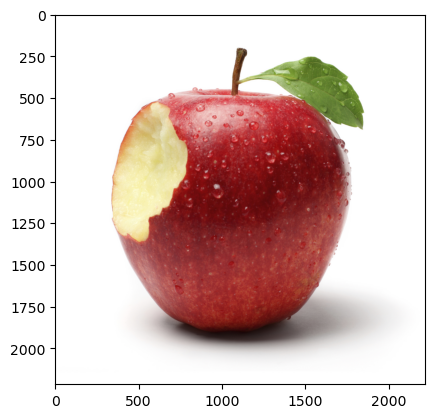

In [5]:
# Check some samples
plt.imshow(keras.utils.load_img('data/train/apple/Image_1.jpg'))
plt.show()

In [6]:
# Specify image size (All images will be resized.)
IMAGE_SIZE = [224, 224]
# Specify batch size
BATCH_SIZE = 128

In [7]:
# Getting number of files, train/test images, classes
train_images_arr = glob('data/train/*/*.jpg')
test_images_arr = glob('data/test/*/*.jpg')
validation_images_arr = glob('data/validation/*/*.jpg')
folders = glob('data/train/*')
folders

['data/train/jalepeno',
 'data/train/lemon',
 'data/train/sweetcorn',
 'data/train/sweetpotato',
 'data/train/cabbage',
 'data/train/orange',
 'data/train/watermelon',
 'data/train/pomegranate',
 'data/train/raddish',
 'data/train/eggplant',
 'data/train/potato',
 'data/train/kiwi',
 'data/train/beetroot',
 'data/train/banana',
 'data/train/soy beans',
 'data/train/lettuce',
 'data/train/spinach',
 'data/train/capsicum',
 'data/train/apple',
 'data/train/carrot',
 'data/train/paprika',
 'data/train/cucumber',
 'data/train/ginger',
 'data/train/garlic',
 'data/train/grapes',
 'data/train/peas',
 'data/train/bell pepper',
 'data/train/chilli pepper',
 'data/train/tomato',
 'data/train/cauliflower',
 'data/train/pineapple',
 'data/train/corn',
 'data/train/pear',
 'data/train/turnip',
 'data/train/mango',
 'data/train/onion']

In [8]:
# Getting images to separate dataframes
def process_img(filepath): # passing the filepaths of datasets
    
    labels = [str(filepath[i]).split("/")[-2] #here we are trying to extract the labels for the fruits and veggies by using .split method and
              for i in range(len(filepath))] #since names are secound last word we used [-2] to get that particular name
                  
    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label') 
    
    df = pd.concat([filepath, labels], axis=1) 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# def process_img_split(filepaths): # passing the filepaths of datasets
    
#     x_arr = []
#     y_arr = []

#     for path in filepaths:
#         # Getting image
#         img = tf.keras.preprocessing.image.load_img(path)
#         # Getting the label of the current image path
#         label = str(path).split("/")[-2]
#         # Appending to data
#         x_arr.append(img)
#         y_arr.append(label)
                  
#     return x_arr, y_arr

In [9]:
train_df = process_img(train_images_arr) 
valid_df = process_img(validation_images_arr)
test_df = process_img(test_images_arr)

train_df.head()

,FilePath,Label
0,data/train/bell pepper/Image_37.jpg,bell pepper
1,data/train/cabbage/Image_55.jpg,cabbage
2,data/train/peas/Image_94.jpg,peas
3,data/train/sweetcorn/Image_27.jpg,sweetcorn
4,data/train/lemon/Image_19.jpg,lemon


In [10]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(set(train_df.Label))}\n')
print(f'Labels: {set(train_df.Label)}') 

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: {'lemon', 'tomato', 'peas', 'cucumber', 'bell pepper', 'apple', 'chilli pepper', 'kiwi', 'cauliflower', 'raddish', 'eggplant', 'onion', 'beetroot', 'paprika', 'cabbage', 'lettuce', 'soy beans', 'turnip', 'sweetpotato', 'orange', 'watermelon', 'pear', 'corn', 'carrot', 'pomegranate', 'potato', 'sweetcorn', 'mango', 'jalepeno', 'grapes', 'garlic', 'ginger', 'spinach', 'pineapple', 'capsicum', 'banana'}


In [11]:
# x_train, y_train = process_img_split(train_images_arr)
# x_valid, y_valid = process_img_split(validation_images_arr)
# x_test, y_test = process_img_split(test_images_arr)

In [12]:
# print('-- Training set --\n')
# print(f'Number of pictures: {len(x_train)}\n')
# print(f'Number of different labels: {len(set(y_train))}\n')
# print(f'Labels: {set(y_train)}') 

In [13]:
# Using pretrained model
ptm = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + [3]
)

# Freezing pretrained model's weight
ptm.trainable = False

2022-08-19 11:19:04.528709: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 11:19:04.530492: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [30]:
# Building the head of the model
K = len(folders)
i = layers.Input(shape=IMAGE_SIZE + [3])
x = layers.Rescaling(scale=1./127.5, offset=-1)(i)
x = layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1])(x)
x = ptm(x, training=False)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(K, activation='softmax')(x)

model = keras.Model(i, x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [31]:
# Creating a generator and making image combinations

data_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input
)

# data_gen.fit(x_train, augment=True)

# train_images = data_gen.flow(
#     x=x_train,
#     y=y_train,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
# )

# valid_images = data_gen.flow(
#     x=x_valid,
#     y=y_valid,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
# )

# test_images = data_gen.flow(
#     x=x_test,
#     y=y_test,
#     batch_size=BATCH_SIZE
# )

train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [32]:
# Fitting
# r = model.fit(
#     train_generator,
#     validation_data=test_generator,
#     validation_steps=int(np.ceil(len(test_images)) / BATCH_SIZE),
#     steps_per_epoch=int(np.ceil(len(train_images)) / BATCH_SIZE),
#     epochs=5
# )

r = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=BATCH_SIZE,
    epochs=24,
    callbacks=[         
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=3,
            restore_best_weights=True #it literally means wat u think (simpleeeeee)
        )
    ]
)

Epoch 1/24
21/87 [======>.......................] - ETA: 1:36 - loss: 5.2628 - accuracy: 0.1027

KeyboardInterrupt: 

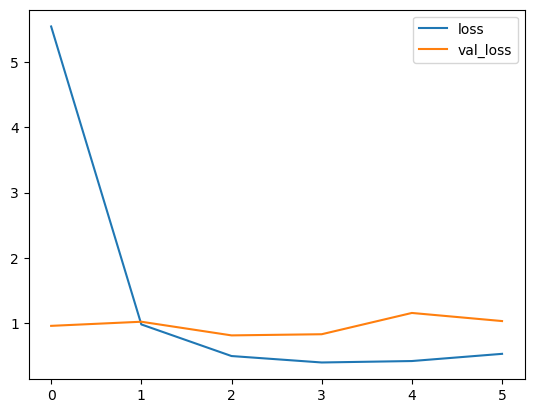

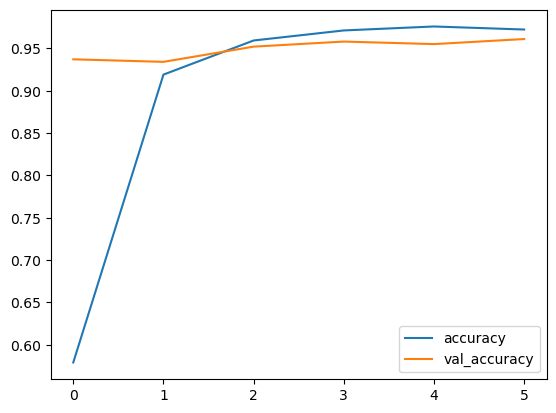

In [125]:
# Plotting the model loss to see the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plotting the model accuracy to see the results
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# valid_generator = gen.flow_from_directory(
#     'data/validation',
#     target_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE
# )

# valid_generator.reset()

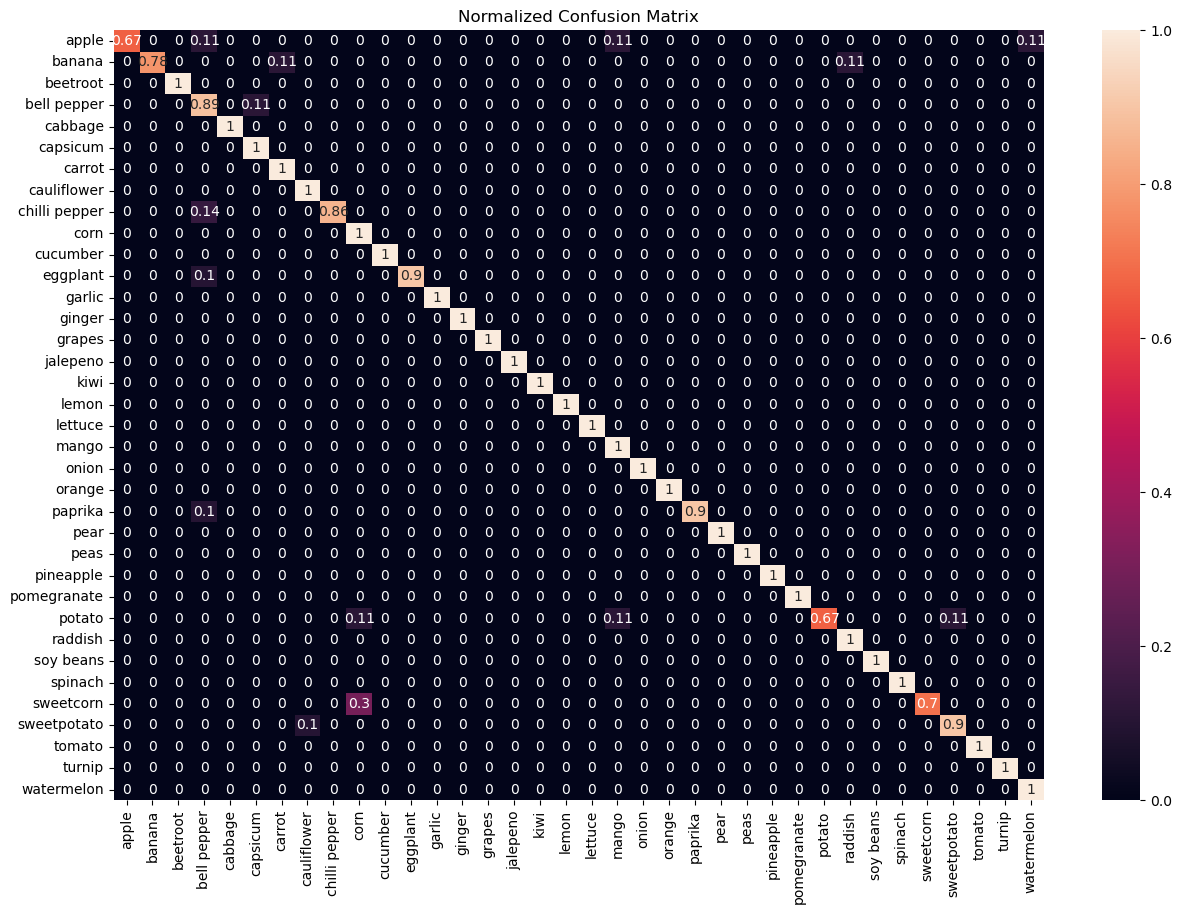

In [126]:
pred = model.predict(test_images) #its predicting time , our model will try to predict the prob of the particular class 
pred = np.argmax(pred, axis=1) # we are seeing the highest prob value and taking the index of it  
labels = (train_images.class_indices) #this gives us the labels with indicie
labels = dict((v,k) for k,v in labels.items()) 
pred = [labels[k] for k in pred] #we are iterating over the pred and taking the label for that particualar value
y_test = [labels[k] for k in test_images.classes]  #we are taking labels fo

from sklearn.metrics import confusion_matrix #lets visualise the model predictions 
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')  
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)), #we put this to see labels
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()



In [89]:
for label in train_images.class_indices:
  print(label)

apple
banana
beetroot
bell pepper
cabbage
capsicum
carrot
cauliflower
chilli pepper
corn
cucumber
eggplant
garlic
ginger
grapes
jalepeno
kiwi
lemon
lettuce
mango
onion
orange
paprika
pear
peas
pineapple
pomegranate
potato
raddish
soy beans
spinach
sweetcorn
sweetpotato
tomato
turnip
watermelon


In [ ]:
# predict

# preds = model.predict_generator(valid_generator, verbose=1, steps=19/BATCH_SIZE)

# print(preds)

NameError: ignored

In [ ]:
# Saving predicted stuffs to dataframe
# predicted_class_indices=np.argmax(preds,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]


# filenames=valid_generator.filenames
# results=pd.DataFrame({"Filename": filenames,
#                       "Predictions": predictions,
#                       "Pred nums": predicted_class_indices})

# results.to_excel('results.xlsx')

In [ ]:
# Print the preds and true labels
# print(valid_generator.class_indices)
# print('-------------------------------')
# print(valid_generator.labels)
# print('-------------------------------')
# print(predicted_class_indices)

In [ ]:
# Plot confusion matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix

# np.set_printoptions(threshold=sys.maxsize)

# cm = confusion_matrix(valid_generator.labels, predicted_class_indices)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_generator.class_indices)
# fig, ax = plt.subplots(figsize=(6,6))
# disp.plot(ax=ax)

In [128]:
# Saving model
saved_model = tf.saved_model.save(model, '/tmp/mobilenetv2_model')

# Converting model to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/mobilenetv2_model')
tflite_model = converter.convert()

# Save the model.
with open('mobilenetv2_model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/mobilenetv2_model/assets


INFO:tensorflow:Assets written to: /tmp/mobilenetv2_model/assets
2022-08-18 17:50:25.713305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-08-18 17:50:25.713478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-08-18 17:50:25.713972: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/mobilenetv2_model
2022-08-18 17:50:25.738117: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-08-18 17:50:25.738159: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/mobilenetv2_model
2022-08-18 17:50:25.829904: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-18 17:50:26.445060: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/mobilenetv2_model
2022-08-18 17:50:26.665258: I tensorflow/cc/saved_model/l

In [ ]:
model.summary

# Tensorflow példa

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers, datasets, preprocessing
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import shutil

In [4]:
# Moving the test datas over to the train dataset
for label in glob('data/test/*'):
    source = os.getcwd() + label
    destination = os.getcwd() + 'data/train'

    i = 1
    for data in glob(f'{label}/*'):
        labelName = label.split('/')[2]
        dataExtension = data.split('.')[1]
        shutil.move(data, f'data/train/{labelName}/Image_Test_{i}.{dataExtension}')
        i += 1

In [5]:
# Specify image size (All images will be resized.)
IMAGE_SIZE = [224, 224]
# Specify batch size
BATCH_SIZE = 128

train_ds = keras.utils.image_dataset_from_directory('data/train',
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMAGE_SIZE)

valid_ds = keras.utils.image_dataset_from_directory('data/validation',
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMAGE_SIZE)

# test_ds = keras.utils.image_dataset_from_directory('data/test',
#                                                     shuffle=True,
#                                                     batch_size=BATCH_SIZE,
#                                                     image_size=IMAGE_SIZE)

Found 3474 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


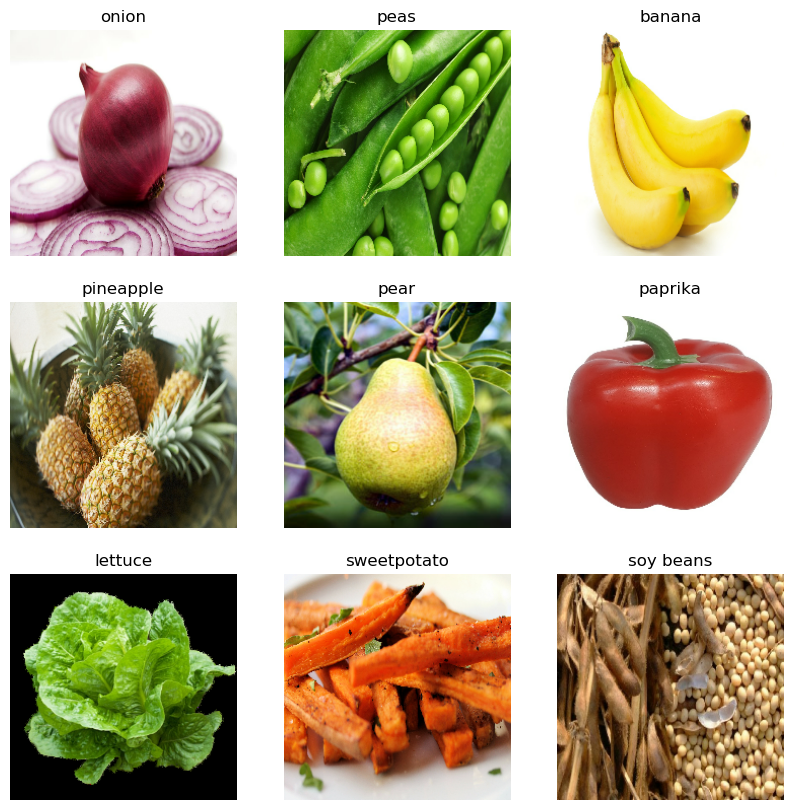

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=(-0.3, 0.2), width_factor=(-0.3, 0.2)),
  layers.RandomContrast(factor=(0.0, 0.2))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


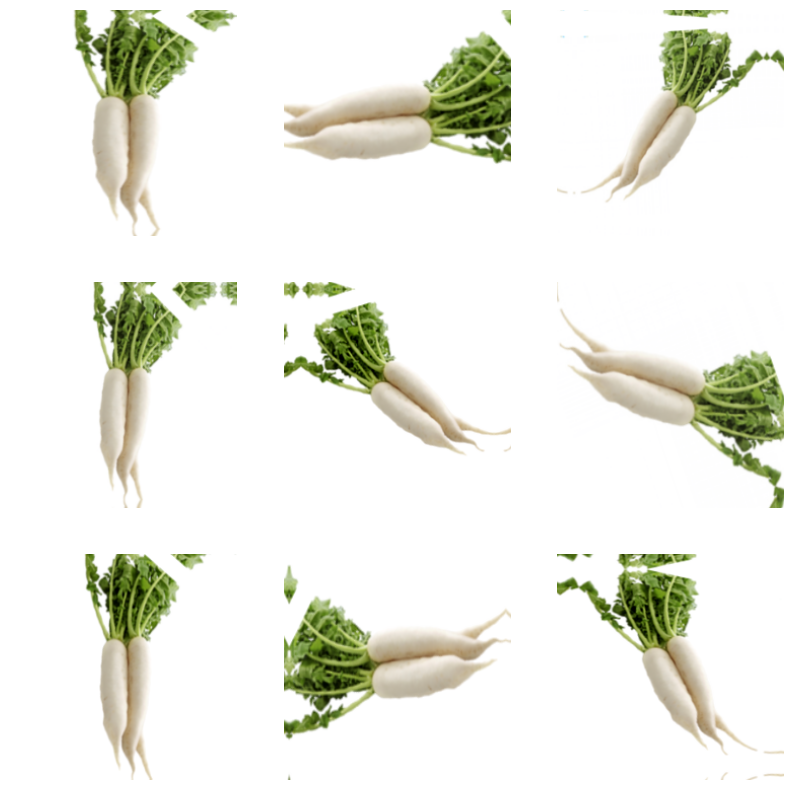

In [8]:
# Some augmented images
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [9]:
# Using pretrained model
ptm = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + [3]
)

# Freezing pretrained model's weight
ptm.trainable = False

In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = ptm(image_batch)
print(feature_batch.shape)


(128, 7, 7, 1280)


In [11]:
# Building the head of the model
K = len(train_ds.class_names)
i = layers.Input(shape=IMAGE_SIZE + [3])
x = data_augmentation(i)
x = layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1])(x)
x = preprocess_input(x)
x = ptm(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(K, activation='softmax')(x)

model = keras.Model(i, x)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
r = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    epochs=36,
    callbacks=[         
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=3,
            restore_best_weights=True #it literally means wat u think (simpleeeeee)
        )
    ]
)

Epoch 1/36
28/28 [==============================] - 105s 3s/step - loss: 0.2584 - accuracy: 0.9217 - val_loss: 0.1146 - val_accuracy: 0.9715
Epoch 2/36
28/28 [==============================] - 98s 3s/step - loss: 0.2545 - accuracy: 0.9231 - val_loss: 0.1109 - val_accuracy: 0.9858
Epoch 3/36
28/28 [==============================] - 97s 3s/step - loss: 0.2622 - accuracy: 0.9157 - val_loss: 0.1127 - val_accuracy: 0.9801
Epoch 4/36
28/28 [==============================] - 98s 3s/step - loss: 0.2466 - accuracy: 0.9263 - val_loss: 0.1054 - val_accuracy: 0.9801
Epoch 5/36
28/28 [==============================] - 96s 3s/step - loss: 0.2373 - accuracy: 0.9280 - val_loss: 0.1120 - val_accuracy: 0.9687
Epoch 6/36
28/28 [==============================] - 92s 3s/step - loss: 0.2341 - accuracy: 0.9263 - val_loss: 0.1083 - val_accuracy: 0.9658
Epoch 7/36
28/28 [==============================] - 92s 3s/step - loss: 0.2300 - accuracy: 0.9298 - val_loss: 0.1062 - val_accuracy: 0.9715


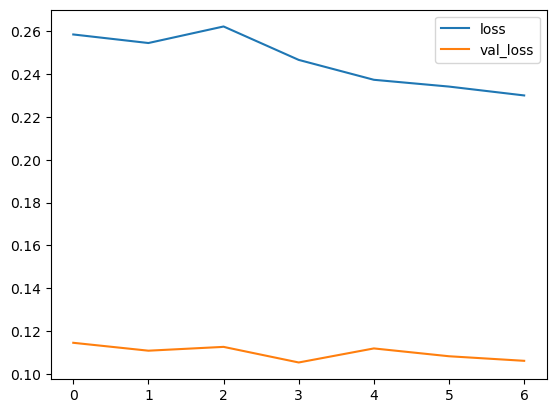

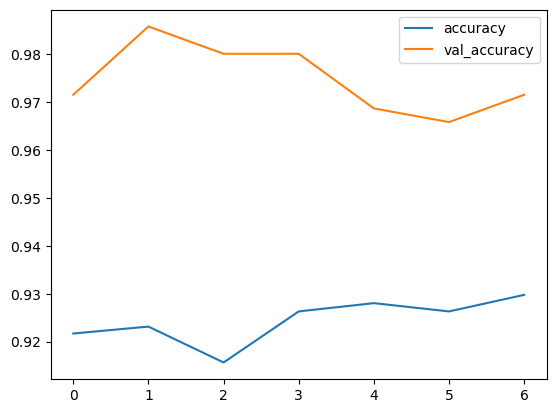

In [16]:
# Plotting the model loss to see the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plotting the model accuracy to see the results
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [17]:
# Saving model
saved_model = tf.saved_model.save(model, '/tmp/mobilenetv2_model')

# Converting model to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/mobilenetv2_model')
tflite_model = converter.convert()

# Save the model.
with open('mobilenetv2_model.tflite', 'wb') as f:
  f.write(tflite_model)
